In [47]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import ijson
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn import preprocessing
from keras.utils import to_categorical
from keras.utils import plot_model
from numpy import array
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt

In [12]:
filepath = 'S:\practice\data\yelp_academic_dataset_review.json'
def load_rows(filepath, nrows = None):
    with open(filepath, encoding='utf8') as json_file:
        count = 0
        objs = []
        line = json_file.readline()
        while (nrows is None or count < nrows) and line:
            count += 1
            obj = json.loads(line)
            objs.append(obj)
            line = json_file.readline()
        return pd.DataFrame(objs)
    
data = load_rows(filepath, 50000)

In [13]:
data.shape

(50000, 9)

In [16]:
yelp_reviews = data.copy()

In [17]:
bins = [0,1,3,5]
review_names = ['bad', 'average', 'good']
yelp_reviews['reviews_score'] = pd.cut(yelp_reviews['stars'], bins, labels=review_names)

In [20]:
yelp_reviews.isnull().values.any()

False

In [21]:
print(yelp_reviews['text'][3])

Dismal, lukewarm, defrosted-tasting "TexMex" glop;

Mumbly, unengaged waiter;

Clueless manager, who seeing us with barely nibbled entrees
on plates shoved forward for pickup, thanked us
perfunctorily for our patronage;

We're from the Texas Hill Country;
down there, we jail critters 
who serve up grub this bad,
for their own protection.

Never, never, NEVER again
(Back to Yard House for real food)


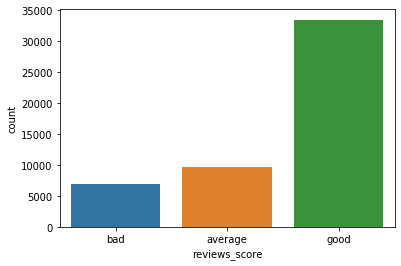

In [24]:
sns.countplot(x='reviews_score', data=yelp_reviews)

## Model with text input only

In [25]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

X = []
sentences = list(yelp_reviews["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = yelp_reviews['reviews_score']

In [28]:
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size=0.20, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 200
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [29]:
embeddings_dictionary = dict()

glove_file = open('S:/practice/data/glove_embeddings/glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] =vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [33]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [34]:
print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 100)          4780900   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 4,898,535
Trainable params: 117,635
Non-trainable params: 4,780,900
_________________________________________________________________
None


In [43]:
# doesn't work
#plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [44]:
history = model.fit(X_train, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
250/250 [==============================] - 129s 514ms/step - loss: 0.8618 - acc: 0.6679 - val_loss: 1.8990 - val_acc: 0.5781
Epoch 2/3
250/250 [==============================] - 133s 532ms/step - loss: 0.8406 - acc: 0.6729 - val_loss: 0.8580 - val_acc: 0.6694
Epoch 3/3
250/250 [==============================] - 128s 510ms/step - loss: 0.8488 - acc: 0.6699 - val_loss: 0.8400 - val_acc: 0.6694


In [45]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 21s 67ms/step - loss: 0.8506 - acc: 0.6660
Test Score: 0.850553035736084
Test Accuracy: 0.6660000085830688


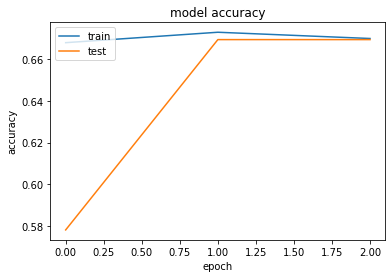

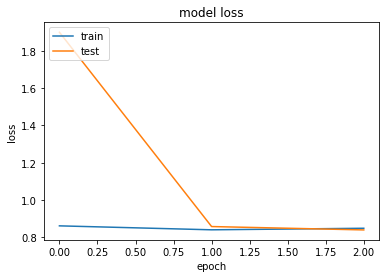

In [48]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Meta variables

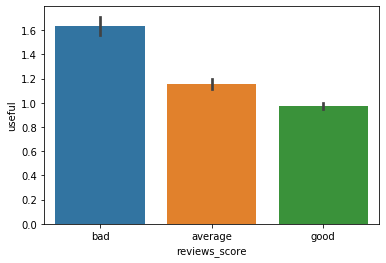

In [49]:
sns.barplot(x='reviews_score', y='useful', data=yelp_reviews)

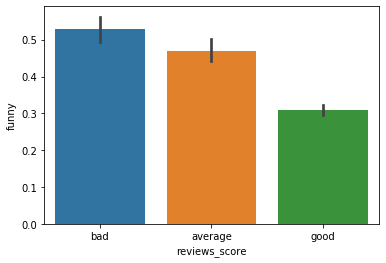

In [50]:
sns.barplot(x='reviews_score', y='funny', data=yelp_reviews)

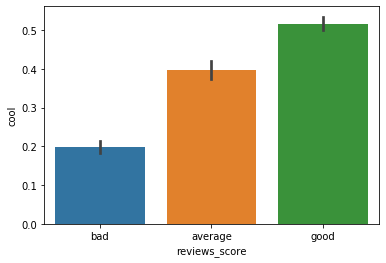

In [51]:
sns.barplot(x='reviews_score', y='cool', data=yelp_reviews)

In [52]:
yelp_reviews_meta = yelp_reviews[['useful', 'funny', 'cool']]

X = yelp_reviews_meta.values

y = yelp_reviews['reviews_score']

label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [53]:
input2 = Input(shape=(3,))
dense_layer_1 = Dense(10, activation='relu')(input2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(3, activation='softmax')(dense_layer_2)

model = Model(inputs=input2, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [54]:
print(model.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.8388 - acc: 0.6731 - val_loss: 0.8171 - val_acc: 0.6760
Epoch 2/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.8153 - acc: 0.6780 - val_loss: 0.8175 - val_acc: 0.6743
Epoch 3/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.8147 - acc: 0.6774 - val_loss: 0.8148 - val_acc: 0.6777
Epoch 4/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8142 - acc: 0.6779 - val_loss: 0.8146 - val_acc: 0.6771
Epoch 5/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.8140 - acc: 0.6778 - val_loss: 0.8155 - val_acc: 0.6774
Epoch 6/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.8142 - acc: 0.6782 - val_loss: 0.8157 - val_acc: 0.6779
Epoch 7/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8138 - acc: 0.6780 - val_loss: 0.8151 - val_acc: 0.6777
Epoch 8/10
2000/2000 [==============================] - 3s 2ms

In [56]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 0s 1ms/step - loss: 0.8259 - acc: 0.6712
Test Score: 0.8259384632110596
Test Accuracy: 0.6711999773979187


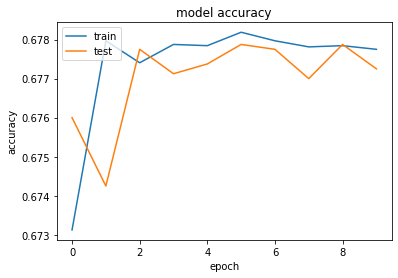

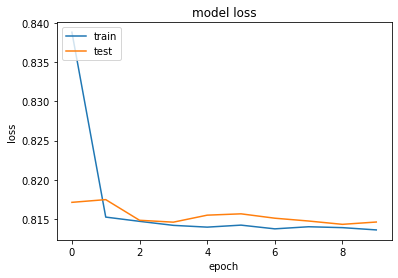

In [57]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Text and Meta inputs both

In [65]:
X = yelp_reviews.drop('reviews_score', axis=1)
y = yelp_reviews['reviews_score']

label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### text sub model

In [66]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))
    
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))
    
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

embeddings_dictionary = dict()

glove_file = open('S:/practice/data/glove_embeddings/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### Meta sub model

In [67]:
X2_train = X_train[['useful', 'funny', 'cool']].values
X2_test = X_test[['useful', 'funny', 'cool']].values

#### Input layers and model

In [68]:
input_1 = Input(shape=(maxlen,))
input_2 = Input(shape=(3,))
# text layers
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
# meta layers
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
# concat both
concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 100)     4780900     input_6[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 10)           40          input_7[0][0]                    
_______________________________________________________________________________________

In [70]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 152s 607ms/step - loss: 0.8425 - acc: 0.6652 - val_loss: 0.7926 - val_acc: 0.6908
Epoch 2/10
250/250 [==============================] - 146s 582ms/step - loss: 0.8241 - acc: 0.6766 - val_loss: 0.7964 - val_acc: 0.6858
Epoch 3/10
250/250 [==============================] - 139s 555ms/step - loss: 0.7832 - acc: 0.6833 - val_loss: 0.8067 - val_acc: 0.6787
Epoch 4/10
250/250 [==============================] - 130s 518ms/step - loss: 0.8038 - acc: 0.6821 - val_loss: 0.7931 - val_acc: 0.6823
Epoch 5/10
250/250 [==============================] - 128s 513ms/step - loss: 0.8099 - acc: 0.6793 - val_loss: 0.8059 - val_acc: 0.6775
Epoch 6/10
250/250 [==============================] - 123s 494ms/step - loss: 0.7997 - acc: 0.6819 - val_loss: 0.8087 - val_acc: 0.6783
Epoch 7/10
250/250 [==============================] - 124s 494ms/step - loss: 0.8002 - acc: 0.6820 - val_loss: 0.8002 - val_acc: 0.6830
Epoch 8/10
250/250 [============================

In [71]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 27s 85ms/step - loss: 0.4674 - acc: 0.8045
Test Score: 0.46744877099990845
Test Accuracy: 0.8044999837875366


In [75]:
prediction = model.predict(x=[X1_test, X2_test], verbose=0)

In [78]:
prediction

array([[0.5352983 , 0.35233244, 0.1123692 ],
       [0.13635367, 0.85089767, 0.01274867],
       [0.01581778, 0.00125774, 0.9829245 ],
       ...,
       [0.03751237, 0.00524212, 0.9572456 ],
       [0.6344086 , 0.04929314, 0.31629828],
       [0.0716614 , 0.00326757, 0.92507106]], dtype=float32)

In [79]:
y_test

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)